# Riemannian Brownian Mixture Model

In [1]:
#Modules

#jax
from jax import jacfwd, vmap, lax
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

import pickle

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

from scipy.io import loadmat

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.statistics.score_matching import BrownianMixtureGrad, BrownianMixtureEM, BrownianMixtureGradEmbedded
from jaxgeometry.statistics.score_matching import BrownianMixtureEMEmbedded
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-19 23:54:53.771403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
t0 = 0.01
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
s2loss_type = "dsm"
s2_type = "s1s2"
seed = 2712
K = 4

figure_path = '../figures/brownian_mixture/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)
    layers_s1, layers_s2 = layers

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval, s1_fun

In [4]:
def load_heat_model(manifold, dim, method="Local"):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1p_path = ''.join((score_path, f"/{manifold}{dim}/s1p_{s1loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)[0]

    s1p_model = hk.transform(lambda x: models.MLP_p(dim=generator_dim, layers=layers)(x))
        
    s1p_state = model_loader.load_model(s1p_path)
    
    rng_key = jrandom.PRNGKey(seed)
    
    if method == "Local":
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x[0],y[0],t)))
    else:
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((M.F(x),M.F(y),t)))
        
    s1p_fun2 = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x,y,t)))
                       
    return s1p_fun, s1p_fun2 

## Testing with $\mathbb{R}^{2}$

In [34]:
M, x0, ScoreEval, _ = load_score_model("Euclidean", 2)
s1p_fun, _ = load_heat_model("Euclidean", 2)

using M.Exp for Logarithm
using M.Exp for Logarithm


### Generate Test Data

In [35]:
std = 0.1
x = []
centers = [jnp.array([-1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([1.0,0.0]), jnp.array([0.0,-1.0])]
for i in range(K):
    eps = std*np.random.normal(size=(100,2))
    x.append(eps+centers[i])
x = jnp.vstack(x)

X_obs = (x, jnp.zeros(len(x)).reshape(-1))

### Testing with True Gradient

In [36]:
RBMM = BrownianMixtureGrad(M=M,
                           log_hk = M.log_hk, #s1p_fun
                           grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           gradt_log=M.gradt_log_hk,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           warmup=100,
                           max_iter=100,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [37]:
#RBMM = BrownianMixtureEM(M=M,
#                           log_hk = M.log_hk, #s1p_fun
#                           grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
#                           gradt_log=M.gradt_log_hk,
#                           n_clusters=4,
#                           eps=0.1,
#                           method='Local',
#                           update_method="Gradient",
#                           grad_iter=100,
#                           em_iter=100,
#                           lr=0.1,
#                           dt_steps=100,
#                           min_t=1e-2,
#                           max_t=1.0,
#                           seed=2712,
#                          )

In [38]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)))

((Array([[[-9.34490794e-01, -4.46528356e-03],
          [ 5.14078936e-03,  9.64539315e-01],
          [-8.56363358e-03, -9.34949973e-01],
          [ 9.44574895e-01,  1.62529130e-02]],
  
         [[-9.40074412e-01, -4.19071947e-03],
          [ 4.92033972e-03,  9.69915643e-01],
          [-8.27140420e-03, -9.40549400e-01],
          [ 9.49906655e-01,  1.61266916e-02]],
  
         [[-9.55268009e-01, -3.38607486e-03],
          [ 4.11754752e-03,  9.84237200e-01],
          [-7.43262700e-03, -9.55668062e-01],
          [ 9.64009229e-01,  1.56826939e-02]],
  
         [[-1.02739501e+00,  4.30791468e-04],
          [ 2.50775148e-04,  1.05283065e+00],
          [-3.42790851e-03, -1.02806788e+00],
          [ 1.03097344e+00,  1.35664748e-02]],
  
         [[-9.19588873e-01, -5.37391945e-03],
          [ 6.88201050e-04,  1.04326726e+00],
          [-8.16789783e-03, -9.42773761e-01],
          [ 1.02170935e+00,  1.38039914e-02]],
  
         [[-1.08091372e+00,  3.41255836e-03],
          [ 5.

In [39]:
T = RBMM.T
mu = RBMM.mu
gradt_log = vmap(lambda x,c: vmap(lambda mu_x, mu_c, t: M.gradt_log_hk((x,c),
                                                                       (mu_x, mu_c),
                                                                       t))(mu[0],
                                                                           mu[1],
                                                                           T))(X_obs[0],
                                                                               X_obs[1])

In [40]:
clusters = RBMM.classify(X_obs)

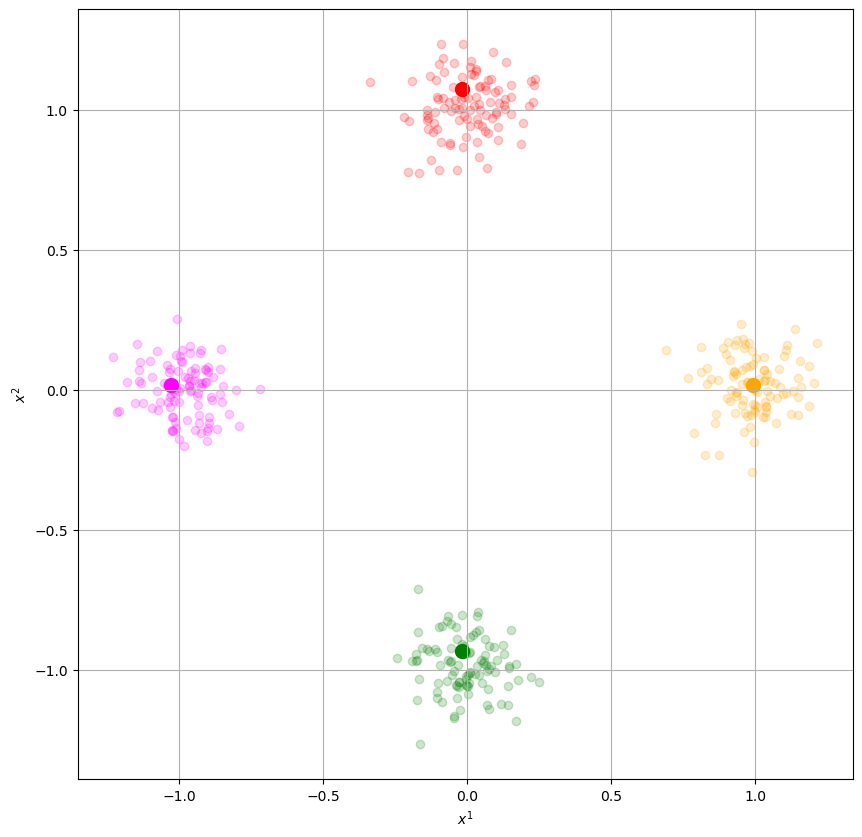

In [41]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
    
for i in range(len(X_obs[0])):
    ax.scatter(X_obs[0][i,0], 
               X_obs[0][i,1], alpha=0.2, color=color[clusters[i]], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

### Testing with Learned Gradient

In [42]:
RBMM = BrownianMixtureEM(M=M,
                           log_hk = s1p_fun, #s1p_fun
                           grady_log=ScoreEval.grady_log,
                           gradt_log=ScoreEval.gradt_log,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           grad_iter=100,
                           em_iter=100,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [43]:
RBMM = BrownianMixtureGrad(M=M,
                           log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
                           grady_log=lambda x,y,t: lax.stop_gradient(ScoreEval.grady_log(x,y,t)),
                           gradt_log=lambda x,y,t: lax.stop_gradient(ScoreEval.gradt_log(x,y,t)),
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           warmup=100,
                           max_iter=100,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [44]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)))

((Array([[[-9.20972927e-01, -1.36032176e-02],
          [ 1.48309273e-02,  9.60645522e-01],
          [-1.06455410e-03, -9.36065870e-01],
          [ 9.37620192e-01,  2.20582018e-02]],
  
         [[-9.27307727e-01, -1.32301494e-02],
          [ 1.32643298e-02,  9.66202125e-01],
          [-1.76358492e-03, -9.41414157e-01],
          [ 9.43164969e-01,  2.13631552e-02]],
  
         [[-9.47227329e-01, -8.45517544e-03],
          [ 8.33486253e-03,  9.82089471e-01],
          [-3.37909051e-03, -9.54943076e-01],
          [ 9.58726097e-01,  1.83127501e-02]],
  
         [[-1.04641590e+00,  7.97188806e-03],
          [-7.47522024e-03,  1.05681090e+00],
          [-1.03008301e-02, -1.02824998e+00],
          [ 1.04202967e+00,  1.00727776e-02]],
  
         [[-8.95763098e-01, -1.65144559e-02],
          [-5.93679044e-03,  1.04608236e+00],
          [-5.77657044e-03, -9.91476225e-01],
          [ 1.02943947e+00,  1.12689649e-02]],
  
         [[-9.11505867e-01, -1.20007832e-02],
          [ 2.

In [45]:
T = RBMM.T
mu = RBMM.mu
gradt_log = vmap(lambda x,c: vmap(lambda mu_x, mu_c, t: M.gradt_log_hk((x,c),
                                                                       (mu_x, mu_c),
                                                                       t))(mu[0],
                                                                           mu[1],
                                                                           T))(X_obs[0],
                                                                               X_obs[1])

In [46]:
clusters = RBMM.classify(X_obs)

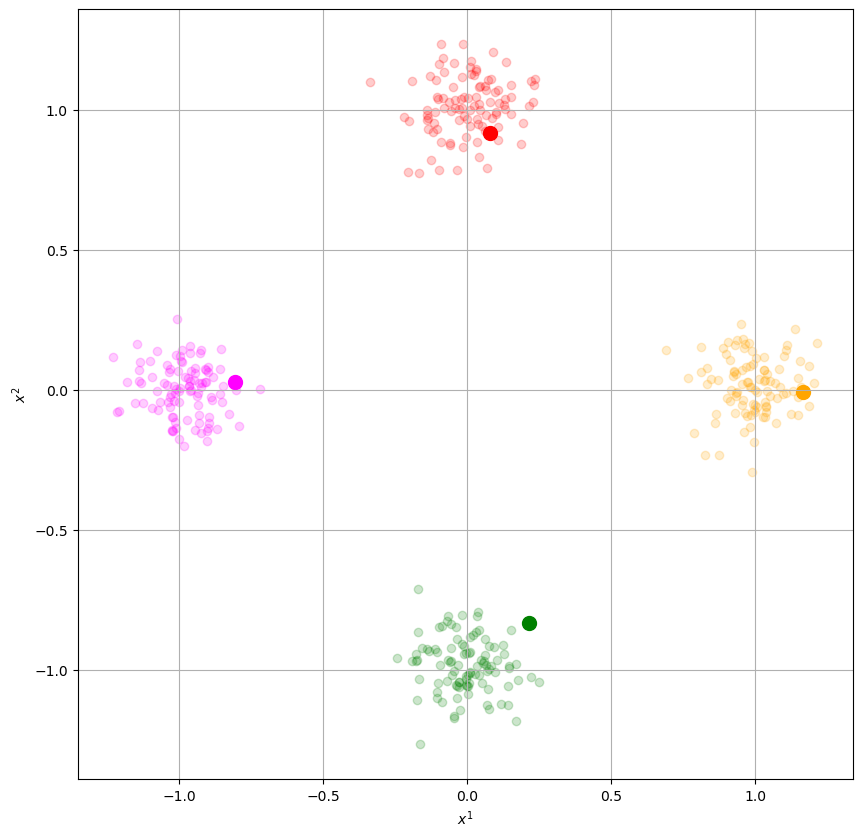

In [47]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
    
for i in range(len(X_obs[0])):
    ax.scatter(X_obs[0][i,0], 
               X_obs[0][i,1], alpha=0.2, color=color[clusters[i]], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

## Application to $\mathbb{S}^{2}$ data

In [48]:
M, x0, ScoreEval, s1_fun = load_score_model("Sphere", 2)
_, s1p_fun = load_heat_model("Sphere", 2)

using M.Exp for Logarithm
using M.Exp for Logarithm


In [49]:
sphere_data = loadmat('../../../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
Xsphere_obs = vmap(lambda chart: ScoreEval.update_coords(chart))(charts)

In [50]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
    

In [51]:
def Exp(x,v):
    
    norm_v = jnp.linalg.norm(v)
    
    return jnp.cos(norm_v)*x+jnp.sin(norm_v)*v/norm_v

In [52]:
def proj(x,v):
    
    return v-jnp.dot(x,v)*x

In [53]:
def grady_log(x,y,t):
        
    if x.ndim == 1:
        return proj(y, s1_fun(x,y,t))
    else:
        return vmap(lambda x1,y1,t1: proj(y1, s1_fun(x1,y1,t1)))(x,y,t)

def gradt_log(x,y,t):

    if x.ndim == 1:
        return ScoreEval.gradt_log(x,y,t)
    else:
        return vmap(lambda x1,y1,t1: ScoreEval.gradt_log(x1,y1,t1))(x,y,t)

In [54]:
def Exp(x,v):
    
    norm_v = jnp.linalg.norm(v)
    
    return jnp.cos(norm_v)*x+jnp.sin(norm_v)*v/norm_v

def proj(x,v):
    
    return v-jnp.dot(x,v)*x

def grady_log(x,y,t):
        
    if x.ndim == 1:
        return proj(y, s1_fun(x,y,t))
    else:
        return vmap(lambda x1,y1,t1: proj(y1, s1_fun(x1,y1,t1)))(x,y,t)

def gradt_log(x,y,t):

    if x.ndim == 1:
        return ScoreEval.gradt_log(x,y,t)
    else:
        return vmap(lambda x1,y1,t1: ScoreEval.gradt_log(x1,y1,t1))(x,y,t)

In [55]:
RBMM = BrownianMixtureGradEmbedded(M=M,
                                   log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
                                   Exp = Exp,
                                   grady_log=lambda x,y,t: lax.stop_gradient(grady_log(x,y,t)),
                                   gradt_log=lambda x,y,t: lax.stop_gradient(gradt_log(x,y,t)),
                                   n_clusters=2,
                                   eps=0.1,
                                   method='Embedded',
                                   update_method="Gradient",
                                   warmup=100,
                                   max_iter=100,
                                   lr=0.1,
                                   dt_steps=100,
                                   min_t=1e-2,
                                   max_t=1.0,
                                   seed=2712,
                                  )

In [56]:
RBMM.fit(Xsphere_obs[1])

[[-0.87479852  0.31878535  0.36483346]
 [ 0.37193681  0.81497602  0.44438395]]


In [57]:
RBMM.mu

Array([[-0.21199354,  0.06154553,  0.97533117],
       [ 0.91276331, -0.07703983,  0.40115832]], dtype=float64)

In [58]:
RBMM.pi(RBMM.alpha)

Array([0.70159198, 0.29840802], dtype=float64)

In [59]:
RBMM.T

Array([0.75918464, 0.01      ], dtype=float64)

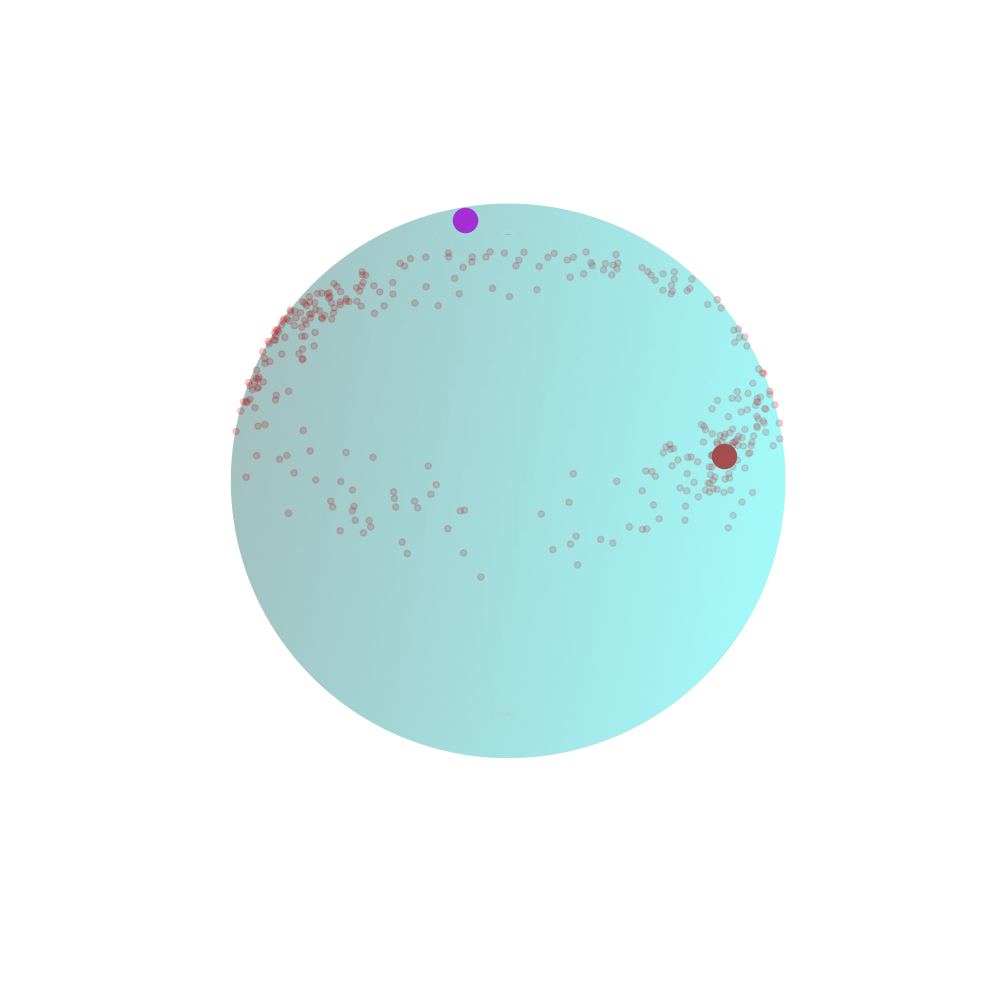

In [60]:
color = ['magenta', 'red', 'green', 'orange', "blue"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(Xsphere_obs[1][:,0], Xsphere_obs[1][:,1], Xsphere_obs[1][:,2], color='red', alpha=0.2)
#ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
j = 0
for center in RBMM.mu:
    ax.scatter(center[0], center[1], center[2], color=color[j], alpha=1.0, s=300, label='Centroids')
    j += 1

#for i in range(len(centroidsm_idxs_s2)):
#    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
#               X_obs[1][centroidsm_idxs_s2[i],1], 
#               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.5, s=100, color=color[i], label='Cluser ' + str(i+1))

#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
#ax.view_init(elev=90, azim=270)
fig.tight_layout()

## $\mathbb{S}^{3}$

In [5]:
data_path = '../data/AFLW2000/head_pose.pkl'

In [6]:
with open(data_path, 'rb') as f:
    data_dict = pickle.load(f)

In [7]:
M, x0, ScoreEval, s1_fun = load_score_model("Sphere", 3)
_, s1p_fun = load_heat_model("Sphere", 3)

using M.Exp for Logarithm
using M.Exp for Logarithm


In [8]:
import cv2
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (jnp.cos(yaw) * jnp.cos(roll)) + tdx
    y1 = size * (jnp.cos(pitch) * jnp.sin(roll) + jnp.cos(roll) * jnp.sin(pitch) * jnp.sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-jnp.cos(yaw) * jnp.sin(roll)) + tdx
    y2 = size * (jnp.cos(pitch) * jnp.cos(roll) - jnp.sin(pitch) * jnp.sin(yaw) * jnp.sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (jnp.sin(yaw)) + tdx
    y3 = size * (-jnp.cos(yaw) * jnp.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [9]:
def toEulerAngles(w,x,y,z):
    
    sinr_cosp = 2*(w*x+y*z)
    cosr_cosp = 1-2*(x*x+y*y)
    roll = jnp.arctan2(sinr_cosp, cosr_cosp)
    
    sinp = jnp.sqrt(1+2*(w*y-x*z))
    cosp = jnp.sqrt(1-2*(w*y-x*z))
    pitch = 2*jnp.arctan2(sinp, cosp)-jnp.pi/2
    
    siny_cosp = 2*(w*z+x*y)
    cosy_cosp = 1-2*(y*y+z*z)
    yaw = jnp.arctan2(siny_cosp, cosy_cosp)
    
    return jnp.stack((roll, pitch, yaw)).T

In [10]:
def euler_to_quaternion(roll, pitch, yaw):
    
    cr = jnp.cos(roll*0.5)
    sr = jnp.sin(roll*0.5)
    cp = jnp.cos(pitch*0.5)
    sp = jnp.sin(pitch*0.5)
    cy = jnp.cos(yaw*0.5)
    sy = jnp.sin(yaw*0.5)
    
    q = jnp.vstack((cr * cp * cy + sr * sp * sy,
                   sr * cp * cy - cr * sp * sy,
                   cr * sp * cy + sr * cp * sy,
                   cr * cp * sy - sr * sp * cy))

    return q.T

def to_sphere(theta, phi):
    
    x1 = jnp.sin(theta)*jnp.cos(phi)
    x2 = jnp.sin(theta)*jnp.sin(phi)
    x3 = jnp.cos(theta)
    
    q = jnp.vstack((x1, x2, x3))

    return q.T

In [11]:
obs = data_dict['train_labels']
X_obs = vmap(lambda x: (M.invF((x,x)), x))(obs)

In [12]:
def Exp(x,v):
    
    norm_v = jnp.linalg.norm(v)
    
    return jnp.cos(norm_v)*x+jnp.sin(norm_v)*v/norm_v

def proj(x,v):
    
    return v-jnp.dot(x,v)*x

def grady_log(x,y,t):
        
    if x.ndim == 1:
        return proj(y, s1_fun(x,y,t))
    else:
        return vmap(lambda x1,y1,t1: proj(y1, s1_fun(x1,y1,t1)))(x,y,t)

def gradt_log(x,y,t):

    if x.ndim == 1:
        return ScoreEval.gradt_log(x,y,t)
    else:
        return vmap(lambda x1,y1,t1: ScoreEval.gradt_log(x1,y1,t1))(x,y,t)

In [13]:
RBMM = BrownianMixtureGradEmbedded(M=M,
                                   log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
                                   Exp = Exp,
                                   grady_log=lambda x,y,t: lax.stop_gradient(grady_log(x,y,t)),
                                   gradt_log=lambda x,y,t: lax.stop_gradient(gradt_log(x,y,t)),
                                   n_clusters=3,
                                   eps=0.1,
                                   method='Embedded',
                                   update_method="Gradient",
                                   warmup=100,
                                   max_iter=100,
                                   lr=0.01,
                                   dt_steps=100,
                                   min_t=1e-2,
                                   max_t=1.0,
                                   seed=2712,
                                  )

In [14]:
#RBMM = BrownianMixtureEMEmbedded(M=M,
#                                   log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
#                                   Exp = Exp,
#                                   grady_log=lambda x,y,t: lax.stop_gradient(grady_log(x,y,t)),
#                                   gradt_log=lambda x,y,t: lax.stop_gradient(gradt_log(x,y,t)),
#                                   n_clusters=3,
#                                   em_iter=10,
#                                   grad_iter=10,
#                                   lr=0.1,
#                                   dt_steps=100,
#                                   min_t=1e-2,
#                                   max_t=1.0,
#                                   seed=2712,
#                                  )

In [15]:
RBMM.fit(X_obs[1])

[[ 0.994616    0.00684333 -0.10284788 -0.01070192]
 [ 0.9515897  -0.17663185 -0.22394632  0.11456925]
 [ 0.92881745  0.18356872 -0.2695516  -0.17590529]]


In [16]:
RBMM.mu

Array([[ 0.9979628 , -0.01249362, -0.06158981,  0.01099958],
       [ 0.971945  , -0.02883016, -0.04875726,  0.22828609],
       [ 0.97456914,  0.01401234, -0.06675696, -0.21345326]],      dtype=float32)

In [17]:
RBMM.pi(RBMM.alpha)

Array([0.3133161 , 0.3438271 , 0.34285682], dtype=float32)

In [18]:
test = RBMM.p_nk(X_obs[1], RBMM.mu, RBMM.T)

In [19]:
test2 = RBMM.gamma_znk(RBMM.alpha, test)

In [20]:
jnp.sum(test2, axis=0)/len(test2)

Array([0.20240083, 0.39829475, 0.39930445], dtype=float32)

In [21]:
RBMM.T

Array([0.01      , 0.10999999, 0.10999999], dtype=float32)

In [22]:
score_idx = RBMM.classify(X_obs[1])

In [23]:
train_euler = toEulerAngles(jnp.array(data_dict['train_labels'])[:,0], 
                            jnp.array(data_dict['train_labels'])[:,1], 
                            jnp.array(data_dict['train_labels'])[:,2], 
                            jnp.array(data_dict['train_labels'])[:,3])

In [24]:
s1_train_euler = to_sphere(train_euler[:,1], train_euler[:,0])

In [25]:
# Creating the theta and phi values.
intervals = 100

theta = jnp.linspace(0.0, jnp.pi*1, intervals)
phi   = jnp.linspace(0.0, jnp.pi*2, intervals)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(intervals))

X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, intervals, intervals), 
                     X2_S2.reshape(1, intervals, intervals), 
                     X3_S2.reshape(1, intervals, intervals))), axes=(1,2,0))

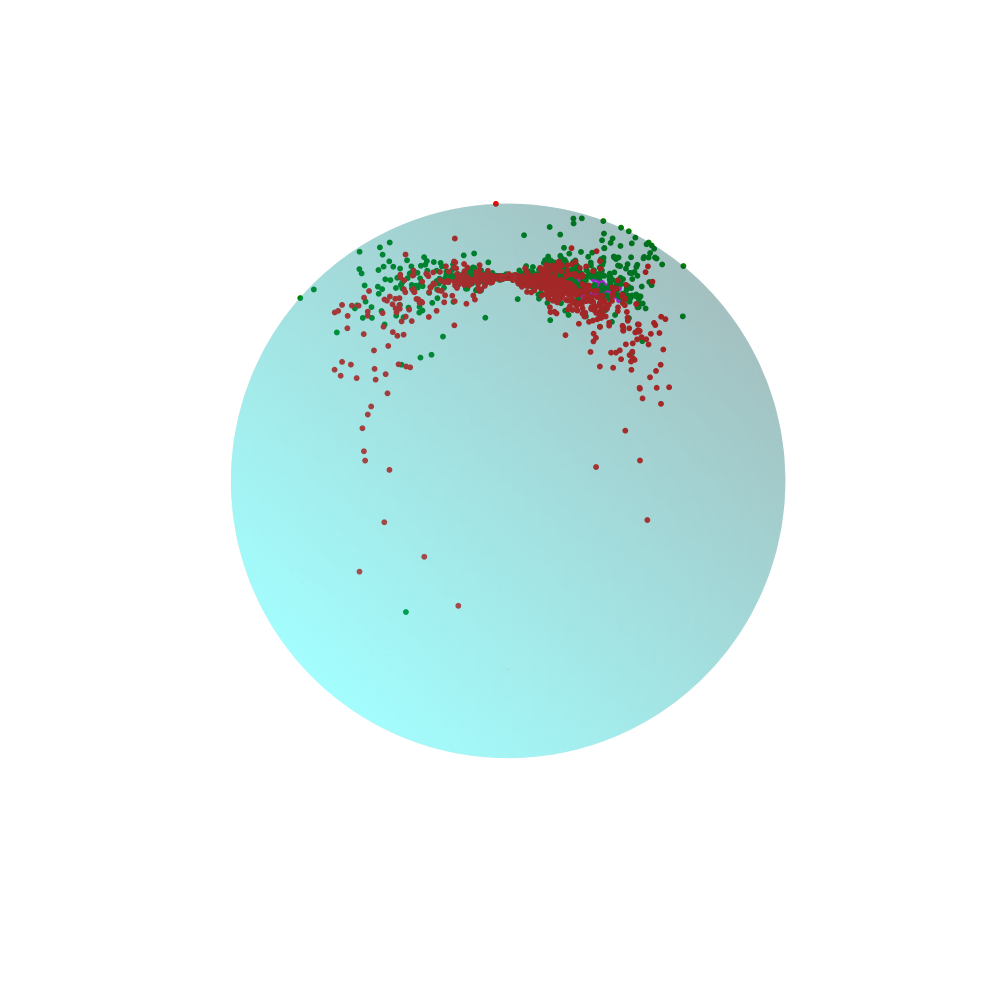

In [26]:
color = ['magenta', 'red', 'green', 'orange', "blue"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2)
for i in range(3):
    idx = (score_idx == i)
    ax.scatter(s1_train_euler[idx,0], s1_train_euler[idx,1], s1_train_euler[idx,2], color=color[i], alpha=1.0, s=10)
#ax.text(s1_train_euler[idx1,0],s1_train_euler[idx1,1],s1_train_euler[idx1,2],  '1', size=100, zorder=1,  
#    color='red', ha='left')
#ax.text(s1_train_euler[idx2,0],s1_train_euler[idx2,1],s1_train_euler[idx2,2],  '2', size=100, zorder=1,  
#    color='red', ha='left')
#ax.text(s1_train_euler[idx3,0],s1_train_euler[idx3,1],s1_train_euler[idx3,2],  '3', size=100, zorder=1,  
#    color='red', ha='left')
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.grid(False)
ax.view_init(elev=45., azim=90)

fig.tight_layout()

fig.savefig(f'{figure_path}mixture_head_pose_s2.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()


In [27]:
img = data_dict['train_original_images']
img_list = []
for i in range(jnp.max(score_idx)+1):
    idx = (score_idx==i)
    img_val = np.array(img)[idx]
    euler1 = train_euler[idx,1]
    euler2 = train_euler[idx,2]
    euler3 = train_euler[idx,0]
    img_sublist = []
    for j in range(len(img_val)):
        img_sublist.append(draw_axis(img_val[j], euler1[j], euler2[j], euler3[j]))
    img_list.append(img_sublist)

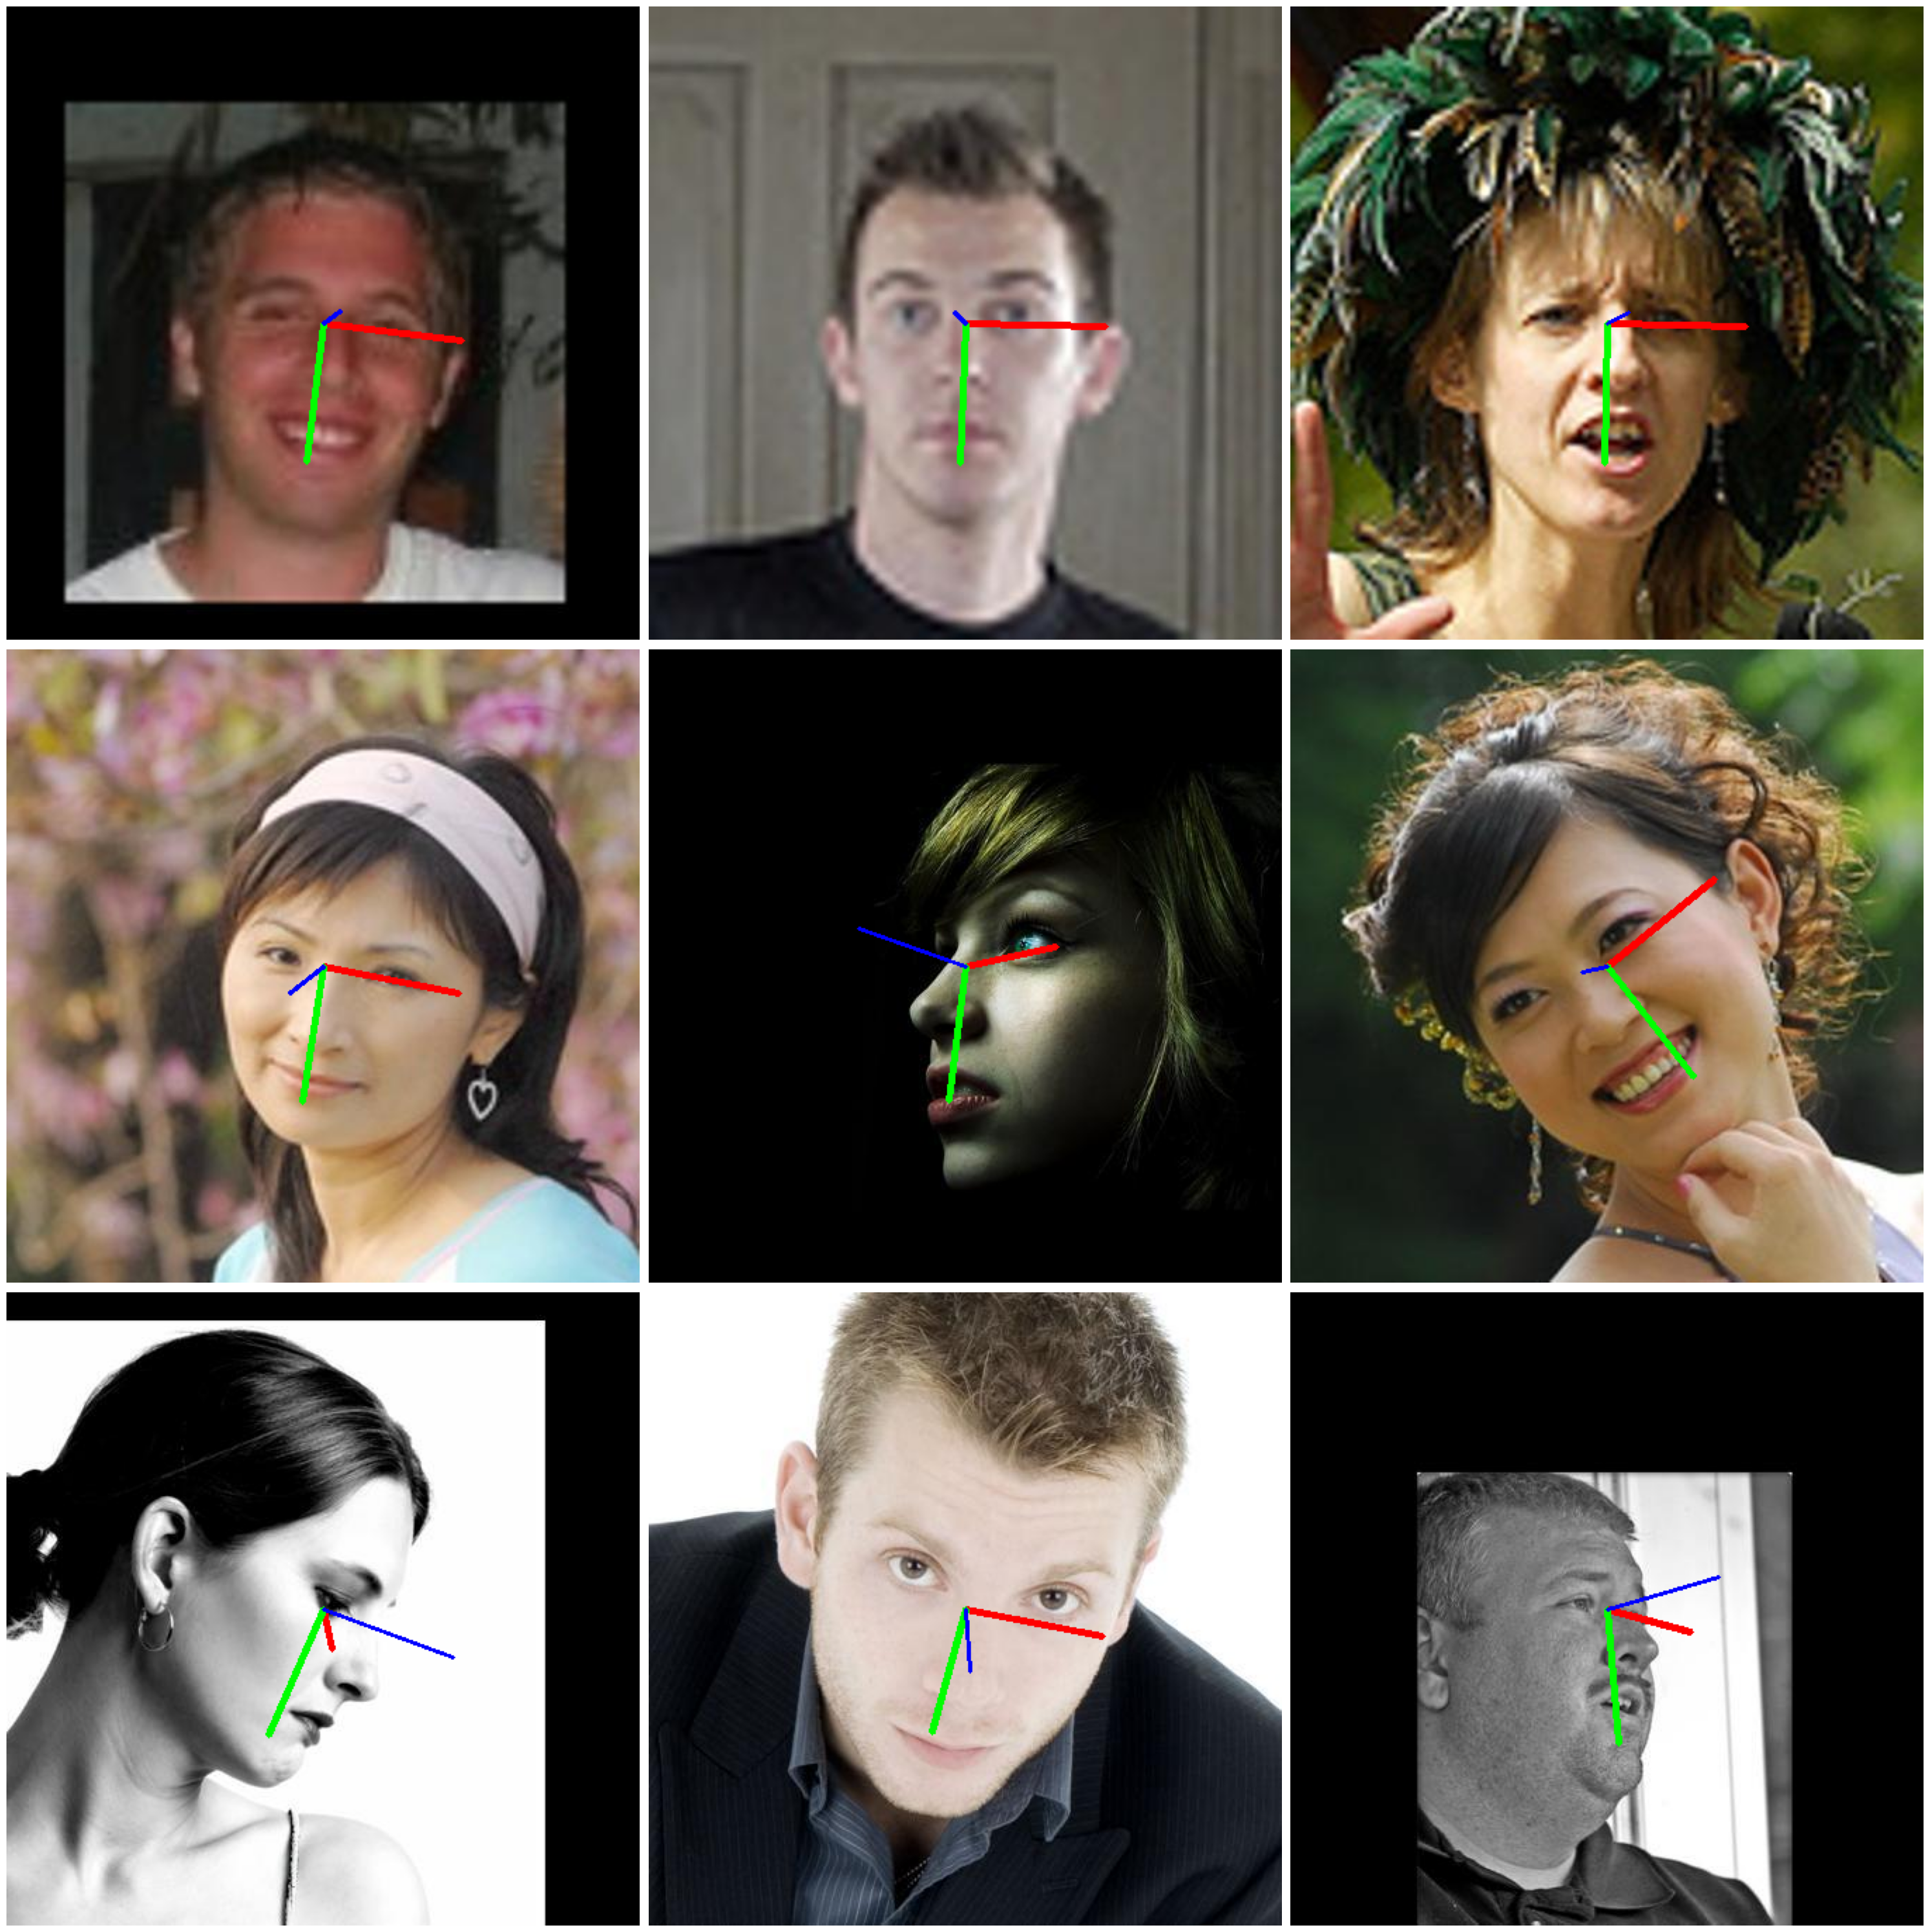

In [28]:
fig = plt.figure(figsize=(30,10*len(img_list)))

for i in range(len(img_list)):
    
    ax = fig.add_subplot(len(img_list), 3, 1+i*3)
    ax.imshow(cv2.cvtColor(img_list[i][0], cv2.COLOR_BGR2RGB))
    ax.set_axis_off()

    ax = fig.add_subplot(len(img_list), 3, 2+i*3)
    ax.imshow(cv2.cvtColor(img_list[i][1], cv2.COLOR_BGR2RGB))
    ax.set_axis_off()

    ax = fig.add_subplot(len(img_list), 3, 3+i*3)
    ax.imshow(cv2.cvtColor(img_list[i][2], cv2.COLOR_BGR2RGB))
    ax.set_axis_off()

fig.tight_layout()
fig.savefig(f'{figure_path}mixture_head_pose.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
